In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob

In [26]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [3]:
import matplotlib.dates as dates
from scipy import stats
from scipy.stats import variation
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
import itertools

In [4]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [5]:
label_fontsize = 16
title_fontsize = 16

In [6]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [7]:
sns.set(font_scale=1.25, style="whitegrid")

In [8]:
%%R
#install.packages("glmnet", repos='http://cran.us.r-project.org')

NULL


In [54]:
%%R
# rm(list = ls())  #remove elements from current workspace
# library("gdata")                   # load gdata package 
library("ggplot2")
# library("psyphy")
# library("plyr")
# library("modelfree")
# library("minpack.lm")
# library("shape")
# library("RColorBrewer")
# library("arm")
# library("glmnet")

In [10]:
%%R
basepath = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
behfilepath = "decArsousalDecisionmaking_JNeuroscience2021/beh_data/csv_files/"

In [11]:
%%R
#read the csv file first (created by process_psychophysics)
csvfile = paste(basepath,behfilepath,"psychophysics.csv",sep="")
myoveralldata = read.csv(csvfile) # read csv file

In [12]:
%%R
head(myoveralldata)

  subj_idx stim leftresp rightresp totresp state
1        2  -60        2         0       2 Alert
2        2  -55        2         0       2 Alert
3        2  -50        2         0       2 Alert
4        2  -45        4         0       4 Alert
5        2  -40        2         0       2 Alert
6        2  -35        4         0       4 Alert


In [13]:
%%R
subj_idxs = unique(myoveralldata$subj_idx)
print(subj_idxs)

 [1]  2  4  5  6  7  9 10 20 21 22 23 24 25 26 27 28 30 31 32 33 34 35 36 37 38
[26] 39 41 42 43 44 45 46


In [14]:
%%R
stats_df <- data.frame(subj_id=character(),alertmean=double(), alertstd=double(),
                       drowsymean=double(), drowsystd=double(),
                       stringsAsFactors=FALSE)
levels(myoveralldata$state) <- c("Alert", "Drowsy") 

In [15]:
%%R
listidx <- seq(1, length(subj_idxs))

myplotdata = NA
myplotalert = NA
myplotdrowsy = NA
for (tempidx in listidx) {
  
  subjid = subj_idxs[tempidx]
  cat("\nProcessing subject:: ", subjid)
  mydata = myoveralldata[myoveralldata$subj_idx == subjid,]
 
  #compute error count with copy data..
  mycopydata <- mydata
  mycopydata$errcnt <- NaN
  lefttrials = mycopydata$stim<0
  mycopydata$errcnt[lefttrials] <-mycopydata$rightresp[lefttrials]
  righttrials = mycopydata$stim>0
  mycopydata$errcnt[righttrials] <-mycopydata$leftresp[righttrials]
    
  # Step 1: Get workable data 
  mydata$p_right = mydata$rightresp / mydata$totresp
  mydata2 <- mydata[complete.cases(mydata),]
  myplotdata <- rbind(myplotdata,mydata2)
  
  mycopydata2 <- mycopydata[complete.cases(mydata),]
  condition1 = c("Alert","Drowsy")
   
  # Step 2: Fit the raw data as sigmoid
  mean_alert = NaN; std_alert = NaN
  mean_drowsy = NaN;std_drowsy = NaN
  
  alert_lefterror = NaN; alert_righterror= NaN
  drowsy_lefterror = NaN; drowsy_righterror= NaN
 
  xseq = seq(-60,60,length.out=100)
  
  alert_data = mydata2[mydata2$state == 'Alert',]
  copyalert_data = mycopydata2[mycopydata2$state == 'Alert',]
  
  if (nrow(alert_data) !=0){
    fitmodel_logit_alert <-
       glm(cbind(rightresp, leftresp) ~ stim, family = binomial(probit),data = alert_data)
    yseq_alert <- predict(fitmodel_logit_alert, data.frame(stim = xseq), type = "response")
    prediction_logit_alert <- data.frame(xseq, yseq_alert)
    
    myplotalert <- rbind(myplotalert,data.frame(subjid, xseq, yseq_alert))
    
    mean_alert <- -coef(fitmodel_logit_alert)[[1]] / coef(fitmodel_logit_alert)[[2]]
    (std_alert <- 1 / coef(fitmodel_logit_alert)[[2]])
    
    lefttrials = copyalert_data$stim<0
    righttrials = copyalert_data$stim>0
    alert_lefterror = sum(copyalert_data$errcnt[lefttrials])
    alert_righterror = sum(copyalert_data$errcnt[righttrials])
    
  }
  
  drowsy_data = mydata2[mydata2$state == 'Drowsy',]
  copydrowsy_data = mycopydata2[mycopydata2$state == 'Drowsy',]
  if (nrow(drowsy_data) !=0){
    fitmodel_logit_drowsy <-
      glm(cbind(rightresp, leftresp) ~ stim, family = binomial(probit),data = drowsy_data)
    yseq_drowsy <- predict(fitmodel_logit_drowsy, data.frame(stim = xseq), type = "response")
    prediction_logit_drowsy <- data.frame(xseq, yseq_drowsy)
      
    myplotdrowsy <- rbind(myplotdrowsy,data.frame(subjid, xseq, yseq_drowsy))
    
    (mean_drowsy <- -coef(fitmodel_logit_drowsy)[[1]] / coef(fitmodel_logit_drowsy)[[2]])
    (std_drowsy <- 1 / coef(fitmodel_logit_drowsy)[[2]])
    
    lefttrials = copydrowsy_data$stim<0
    righttrials = copydrowsy_data$stim>0
    drowsy_lefterror = sum(copydrowsy_data$errcnt[lefttrials])
    drowsy_righterror = sum(copydrowsy_data$errcnt[righttrials])
  }
  
  biasstring = paste("Alert bias =", round(mean_alert, digits = 2),"(", alert_lefterror,"/", alert_righterror,")",
                     "\nDrowsy bias =", round(mean_drowsy, digits = 2),"(", drowsy_lefterror,"/", drowsy_righterror,")")#,
  
  subjstring = paste("Subj_",subjid,":Righthander",sep="")
  
  # store the data for stats now..
  datalist <- list(toString(subjid),mean_alert,std_alert,mean_drowsy,std_drowsy)
  
  stats_df[tempidx,] <- datalist
  
}

tmp_idx = which(stats_df$drowsystd>30,)
stats_df[tmp_idx,"drowsystd"] = NaN; #stats_df[tmp_idx,"drowsy1mean"] = NaN
tmp_idx = which(abs(stats_df$drowsymean)>60,)
stats_df[tmp_idx,"drowsymean"] = NaN;#stats_df[tmp_idx,"drowsy1std"] = NaN

stats_df$meandiff = stats_df$alertmean - stats_df$drowsymean

myplotdata = myplotdata[-1,]
myplotalert = myplotalert[-1,]
myplotdrowsy = myplotdrowsy[-1,]


Processing subject::  2
Processing subject::  4
Processing subject::  5
Processing subject::  6
Processing subject::  7
Processing subject::  9
Processing subject::  10
Processing subject::  20
Processing subject::  21
Processing subject::  22
Processing subject::  23
Processing subject::  24
Processing subject::  25
Processing subject::  26
Processing subject::  27
Processing subject::  28
Processing subject::  30
Processing subject::  31
Processing subject::  32
Processing subject::  33
Processing subject::  34
Processing subject::  35
Processing subject::  36
Processing subject::  37
Processing subject::  38
Processing subject::  39
Processing subject::  41
Processing subject::  42
Processing subject::  43
Processing subject::  44
Processing subject::  45
Processing subject::  46

In [16]:
%%R
print(stats_df[listidx,])
leftshift = sum(stats_df$meandiff>0, na.rm = TRUE)
rightshift = sum(stats_df$meandiff<0, na.rm = TRUE)
NAshift = sum(is.na(stats_df$meandiff), na.rm = TRUE)

   subj_id   alertmean  alertstd  drowsymean  drowsystd     meandiff
1        2  -2.7067611  3.881901 -10.9634696 23.3319684   8.25670856
2        4   6.0981752  6.009543  10.8625569 21.0000763  -4.76438167
3        5   3.2425195 14.393248 -11.7436918 25.4042652  14.98621132
4        6  -0.8421336  9.687243  -4.9263311 24.7862273   4.08419752
5        7   2.0699476  6.460131   0.7849835 17.7088685   1.28496403
6        9   0.3566976  6.605309  34.1554272        NaN -33.79872961
7       10   4.5455976  4.270522   0.7256004  3.6652926   3.81999727
8       20  -1.5702106  8.191219  -9.1180497 18.0262497   7.54783910
9       21  -5.0944463 10.083819  -7.6852101        NaN   2.59076379
10      22   7.4757796  1.232483   7.4868210  0.4412645  -0.01104145
11      23  -0.4824549 12.308442   4.6828582 23.1354639  -5.16531312
12      24  -7.5289022 15.470718 -43.5850830        NaN  36.05618075
13      25  -1.7371462 16.250685  -0.6404219 14.1288375  -1.09672420
14      26   1.0923905 19.503781  

In [17]:
%%R
print(head(myplotdata))
print(tail(myplotdata))
print(leftshift)
print(rightshift)
print(NAshift)

  subj_idx stim leftresp rightresp totresp state p_right
2        2  -60        2         0       2 Alert       0
3        2  -55        2         0       2 Alert       0
4        2  -50        2         0       2 Alert       0
5        2  -45        4         0       4 Alert       0
6        2  -40        2         0       2 Alert       0
7        2  -35        4         0       4 Alert       0
     subj_idx stim leftresp rightresp totresp  state p_right
1595       46   35        0         4       4 Drowsy       1
1596       46   40        0         5       5 Drowsy       1
1597       46   45        0         3       3 Drowsy       1
1598       46   50        0         5       5 Drowsy       1
1599       46   55        0         1       1 Drowsy       1
1600       46   60        0         2       2 Drowsy       1
[1] 24
[1] 7
[1] 1


In [19]:
%%R
leftshiftidx = stats_df$meandiff>0 & !is.na(stats_df$meandiff)
rightshiftidx = stats_df$meandiff<0 & !is.na(stats_df$meandiff)
NAshiftidx = is.na(stats_df$meandiff)
leftshift_subj = stats_df$subj_id[leftshiftidx]
rightshift_subj = stats_df$subj_id[rightshiftidx]
NAshift_subj = stats_df$subj_id[NAshiftidx]
cat("\nLeftshifting subjects: ", leftshift_subj)
cat("\nRightshifting subjects: ", rightshift_subj)
cat("\nNAshifting subjects: ", NAshift_subj)


Leftshifting subjects:  2 5 6 7 10 20 21 24 26 27 28 30 31 33 34 35 36 37 39 42 43 44 45 46
Rightshifting subjects:  4 9 22 23 25 32 38
NAshifting subjects:  41

In [20]:
%%R
print(head(myplotalert))
print(tail(myplotalert))
print(head(myplotdrowsy))
print(tail(myplotdrowsy))

    subjid      xseq   yseq_alert
110      2 -60.00000 2.220446e-16
2        2 -58.78788 2.220446e-16
3        2 -57.57576 2.220446e-16
4        2 -56.36364 2.220446e-16
5        2 -55.15152 2.220446e-16
6        2 -53.93939 2.220446e-16
      subjid     xseq yseq_alert
9531      46 53.93939          1
9631      46 55.15152          1
9731      46 56.36364          1
9831      46 57.57576          1
9931      46 58.78788          1
10031     46 60.00000          1
    subjid      xseq yseq_drowsy
110      2 -60.00000  0.01779028
2        2 -58.78788  0.02019503
3        2 -57.57576  0.02286991
4        2 -56.36364  0.02583727
5        2 -55.15152  0.02912019
6        2 -53.93939  0.03274247
      subjid     xseq yseq_drowsy
9531      46 53.93939   0.9990071
9631      46 55.15152   0.9991792
9731      46 56.36364   0.9993235
9831      46 57.57576   0.9994441
9931      46 58.78788   0.9995445
10031     46 60.00000   0.9996279


In [21]:
%%R
stats_df

   subj_id   alertmean  alertstd  drowsymean  drowsystd     meandiff
1        2  -2.7067611  3.881901 -10.9634696 23.3319684   8.25670856
2        4   6.0981752  6.009543  10.8625569 21.0000763  -4.76438167
3        5   3.2425195 14.393248 -11.7436918 25.4042652  14.98621132
4        6  -0.8421336  9.687243  -4.9263311 24.7862273   4.08419752
5        7   2.0699476  6.460131   0.7849835 17.7088685   1.28496403
6        9   0.3566976  6.605309  34.1554272        NaN -33.79872961
7       10   4.5455976  4.270522   0.7256004  3.6652926   3.81999727
8       20  -1.5702106  8.191219  -9.1180497 18.0262497   7.54783910
9       21  -5.0944463 10.083819  -7.6852101        NaN   2.59076379
10      22   7.4757796  1.232483   7.4868210  0.4412645  -0.01104145
11      23  -0.4824549 12.308442   4.6828582 23.1354639  -5.16531312
12      24  -7.5289022 15.470718 -43.5850830        NaN  36.05618075
13      25  -1.7371462 16.250685  -0.6404219 14.1288375  -1.09672420
14      26   1.0923905 19.503781  

In [22]:
%%R
completestats_df = stats_df[complete.cases(stats_df), ]
print(completestats_df)
print(dim(completestats_df))

   subj_id   alertmean  alertstd  drowsymean  drowsystd    meandiff
1        2  -2.7067611  3.881901 -10.9634696 23.3319684  8.25670856
2        4   6.0981752  6.009543  10.8625569 21.0000763 -4.76438167
3        5   3.2425195 14.393248 -11.7436918 25.4042652 14.98621132
4        6  -0.8421336  9.687243  -4.9263311 24.7862273  4.08419752
5        7   2.0699476  6.460131   0.7849835 17.7088685  1.28496403
7       10   4.5455976  4.270522   0.7256004  3.6652926  3.81999727
8       20  -1.5702106  8.191219  -9.1180497 18.0262497  7.54783910
10      22   7.4757796  1.232483   7.4868210  0.4412645 -0.01104145
11      23  -0.4824549 12.308442   4.6828582 23.1354639 -5.16531312
13      25  -1.7371462 16.250685  -0.6404219 14.1288375 -1.09672420
14      26   1.0923905 19.503781  -9.6423712 24.6779501 10.73476167
15      27  -7.4553435  2.000238 -12.3438031 19.3101135  4.88845963
16      28  -8.3307983 18.248090 -14.7492168 23.3865484  6.41841846
17      30  -5.7507529  7.422915  -7.9986529 24.

In [23]:
%%R
print(cor.test(abs(completestats_df$alertmean),completestats_df$alertstd))
print(cor.test(abs(completestats_df$drowsymean),completestats_df$drowsystd))


	Pearson's product-moment correlation

data:  abs(completestats_df$alertmean) and completestats_df$alertstd
t = -0.4347, df = 19, p-value = 0.6687
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5091127  0.3473303
sample estimates:
        cor 
-0.09923567 


	Pearson's product-moment correlation

data:  abs(completestats_df$drowsymean) and completestats_df$drowsystd
t = 2.2251, df = 19, p-value = 0.03839
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02858188 0.74092429
sample estimates:
      cor 
0.4546589 



In [27]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [29]:
df_myplotdata = robjects.r('myplotdata')
df_alert = robjects.r('myplotalert')
df_drowsy = robjects.r('myplotdrowsy')
df_stats = robjects.r('stats_df[listidx,]')
df_rightshifter = robjects.r('rightshift_subj')
df_leftshifter = robjects.r('leftshift_subj')
df_leftshiftnums = robjects.r('leftshift')
df_rightshiftnums = robjects.r('rightshift')
df_NAshiftnums = robjects.r('NAshift')

In [30]:
df_rightshifter = np.asfarray(df_rightshifter,float)
df_leftshifter = np.asfarray(df_leftshifter,float)

In [31]:
df_myplotdata.head()

,subj_idx,stim,leftresp,rightresp,totresp,state,p_right
2,2.0,-60.0,2.0,0.0,2.0,Alert,0.0
3,2.0,-55.0,2.0,0.0,2.0,Alert,0.0
4,2.0,-50.0,2.0,0.0,2.0,Alert,0.0
5,2.0,-45.0,4.0,0.0,4.0,Alert,0.0
6,2.0,-40.0,2.0,0.0,2.0,Alert,0.0


In [32]:
df_alert

,subjid,xseq,yseq_alert
110,2.0,-60.000000,2.220446e-16
2,2.0,-58.787879,2.220446e-16
3,2.0,-57.575758,2.220446e-16
4,2.0,-56.363636,2.220446e-16
5,2.0,-55.151515,2.220446e-16
...,...,...,...
9631,46.0,55.151515,1.000000e+00
9731,46.0,56.363636,1.000000e+00
9831,46.0,57.575758,1.000000e+00
9931,46.0,58.787879,1.000000e+00


In [33]:
df_drowsy

,subjid,xseq,yseq_drowsy
110,2.0,-60.000000,0.017790
2,2.0,-58.787879,0.020195
3,2.0,-57.575758,0.022870
4,2.0,-56.363636,0.025837
5,2.0,-55.151515,0.029120
...,...,...,...
9631,46.0,55.151515,0.999179
9731,46.0,56.363636,0.999324
9831,46.0,57.575758,0.999444
9931,46.0,58.787879,0.999545


In [34]:
df_stats.head()

,subj_id,alertmean,alertstd,drowsymean,drowsystd,meandiff
1,2,-2.706761,3.881901,-10.963470,23.331968,8.256709
2,4,6.098175,6.009543,10.862557,21.000076,-4.764382
3,5,3.242519,14.393248,-11.743692,25.404265,14.986211
4,6,-0.842134,9.687243,-4.926331,24.786227,4.084198
5,7,2.069948,6.460131,0.784984,17.708869,1.284964


In [35]:
df_alert['Condition']='Alert'
df_alert = df_alert.rename(columns={'yseq_alert': 'yseq'})
df_alert

,subjid,xseq,yseq,Condition
110,2.0,-60.000000,2.220446e-16,Alert
2,2.0,-58.787879,2.220446e-16,Alert
3,2.0,-57.575758,2.220446e-16,Alert
4,2.0,-56.363636,2.220446e-16,Alert
5,2.0,-55.151515,2.220446e-16,Alert
...,...,...,...,...
9631,46.0,55.151515,1.000000e+00,Alert
9731,46.0,56.363636,1.000000e+00,Alert
9831,46.0,57.575758,1.000000e+00,Alert
9931,46.0,58.787879,1.000000e+00,Alert


In [36]:
df_drowsy['Condition']='Drowsy'
df_drowsy = df_drowsy.rename(columns={'yseq_drowsy': 'yseq'})
df_drowsy

,subjid,xseq,yseq,Condition
110,2.0,-60.000000,0.017790,Drowsy
2,2.0,-58.787879,0.020195,Drowsy
3,2.0,-57.575758,0.022870,Drowsy
4,2.0,-56.363636,0.025837,Drowsy
5,2.0,-55.151515,0.029120,Drowsy
...,...,...,...,...
9631,46.0,55.151515,0.999179,Drowsy
9731,46.0,56.363636,0.999324,Drowsy
9831,46.0,57.575758,0.999444,Drowsy
9931,46.0,58.787879,0.999545,Drowsy


In [37]:
group_df = pd.concat([df_alert,df_drowsy],axis=0, sort=False)

In [38]:
group_df

,subjid,xseq,yseq,Condition
110,2.0,-60.000000,2.220446e-16,Alert
2,2.0,-58.787879,2.220446e-16,Alert
3,2.0,-57.575758,2.220446e-16,Alert
4,2.0,-56.363636,2.220446e-16,Alert
5,2.0,-55.151515,2.220446e-16,Alert
...,...,...,...,...
9631,46.0,55.151515,9.991792e-01,Drowsy
9731,46.0,56.363636,9.993235e-01,Drowsy
9831,46.0,57.575758,9.994441e-01,Drowsy
9931,46.0,58.787879,9.995445e-01,Drowsy


In [39]:
group_alertmean = df_alert.groupby(['xseq']).mean()
group_alertmean = group_alertmean.drop(columns = 'subjid')
group_alertmean.index.name = 'xseq'
group_alertmean.reset_index(inplace=True)
group_alertmean = group_alertmean.rename(columns={'yseq': 'yseq_alertmean'})
group_alertmean

,xseq,yseq_alertmean
0,-60.000000,0.005048
1,-58.787879,0.005551
2,-57.575758,0.006101
3,-56.363636,0.006700
4,-55.151515,0.007352
...,...,...
95,55.151515,0.991204
96,56.363636,0.991624
97,57.575758,0.992019
98,58.787879,0.992393


In [40]:
group_drowsymean = df_drowsy.groupby(['xseq']).mean()
group_drowsymean = group_drowsymean.drop(columns = 'subjid')
group_drowsymean.index.name = 'xseq'
group_drowsymean.reset_index(inplace=True)
group_drowsymean = group_drowsymean.rename(columns={'yseq': 'yseq_drowsymean'})
group_drowsymean

,xseq,yseq_drowsymean
0,-60.000000,0.105805
1,-58.787879,0.109133
2,-57.575758,0.112589
3,-56.363636,0.116182
4,-55.151515,0.119919
...,...,...
95,55.151515,0.964265
96,56.363636,0.965520
97,57.575758,0.966713
98,58.787879,0.967847


In [41]:
import rpy2.robjects as ro

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
  r_group_alertmean = ro.conversion.py2rpy(group_alertmean)

with localconverter(ro.default_converter + pandas2ri.converter):
  r_group_drowsymean = ro.conversion.py2rpy(group_drowsymean)

with localconverter(ro.default_converter + pandas2ri.converter):
  r_group_df = ro.conversion.py2rpy(group_df)

In [42]:
robjects.globalenv["r_group_alertmean"] = r_group_alertmean
robjects.globalenv["r_group_drowsymean"] = r_group_drowsymean
robjects.globalenv["r_group_df"] = r_group_df

In [43]:
%%R
print(head(myoveralldata))
print(tail(myoveralldata))

  subj_idx stim leftresp rightresp totresp state
1        2  -60        2         0       2 Alert
2        2  -55        2         0       2 Alert
3        2  -50        2         0       2 Alert
4        2  -45        4         0       4 Alert
5        2  -40        2         0       2 Alert
6        2  -35        4         0       4 Alert
     subj_idx stim leftresp rightresp totresp  state
1595       46   35        0         4       4 Drowsy
1596       46   40        0         5       5 Drowsy
1597       46   45        0         3       3 Drowsy
1598       46   50        0         5       5 Drowsy
1599       46   55        0         1       1 Drowsy
1600       46   60        0         2       2 Drowsy


In [44]:
%%R
r_group_alert = myoveralldata[myoveralldata$state == 'Alert',]
print(head(r_group_alert))
print(tail(r_group_alert))

  subj_idx stim leftresp rightresp totresp state
1        2  -60        2         0       2 Alert
2        2  -55        2         0       2 Alert
3        2  -50        2         0       2 Alert
4        2  -45        4         0       4 Alert
5        2  -40        2         0       2 Alert
6        2  -35        4         0       4 Alert
     subj_idx stim leftresp rightresp totresp state
1570       46   35        0         4       4 Alert
1571       46   40        0         2       2 Alert
1572       46   45        0         4       4 Alert
1573       46   50        0         2       2 Alert
1574       46   55        0         2       2 Alert
1575       46   60        0         2       2 Alert


In [45]:
%%R
r_group_drowsy = myoveralldata[myoveralldata$state == 'Drowsy',]
print(head(r_group_drowsy))
print(tail(r_group_drowsy))

   subj_idx stim leftresp rightresp totresp  state
26        2  -60        5         0       5 Drowsy
27        2  -55        7         1       8 Drowsy
28        2  -50        7         0       7 Drowsy
29        2  -45       12         2      14 Drowsy
30        2  -40        7         0       7 Drowsy
31        2  -35        8         0       8 Drowsy
     subj_idx stim leftresp rightresp totresp  state
1595       46   35        0         4       4 Drowsy
1596       46   40        0         5       5 Drowsy
1597       46   45        0         3       3 Drowsy
1598       46   50        0         5       5 Drowsy
1599       46   55        0         1       1 Drowsy
1600       46   60        0         2       2 Drowsy


In [46]:
%%R
head(r_group_alertmean)

       xseq yseq_alertmean
0 -60.00000    0.005047537
1 -58.78788    0.005551498
2 -57.57576    0.006100929
3 -56.36364    0.006699697
4 -55.15152    0.007352043
5 -53.93939    0.008062636


In [47]:
%%R
head(r_group_drowsymean)

       xseq yseq_drowsymean
0 -60.00000       0.1058052
1 -58.78788       0.1091328
2 -57.57576       0.1125892
3 -56.36364       0.1161820
4 -55.15152       0.1199193
5 -53.93939       0.1238098


In [48]:
%%R
head(r_group_alert)

  subj_idx stim leftresp rightresp totresp state
1        2  -60        2         0       2 Alert
2        2  -55        2         0       2 Alert
3        2  -50        2         0       2 Alert
4        2  -45        4         0       4 Alert
5        2  -40        2         0       2 Alert
6        2  -35        4         0       4 Alert


In [49]:
%%R
fitmodel_logit_groupalert <- glm(cbind(rightresp, leftresp) ~ stim, family = binomial(probit),data = r_group_alert)
yseq_groupalert <- predict(fitmodel_logit_groupalert, data.frame(stim = xseq), type = "response")
prediction_logit_groupalert <- data.frame(xseq, yseq_groupalert)
head(prediction_logit_groupalert)

       xseq yseq_groupalert
1 -60.00000    0.0001011944
2 -58.78788    0.0001371406
3 -57.57576    0.0001848008
4 -56.36364    0.0002476132
5 -55.15152    0.0003298988
6 -53.93939    0.0004370485


In [50]:
%%R
mean_groupalert <- -coef(fitmodel_logit_groupalert)[[1]] / coef(fitmodel_logit_groupalert)[[2]]
std_groupalert <- 1 / coef(fitmodel_logit_alert)[[2]]
mean_groupalert

[1] -1.928145


In [51]:
%%R
fitmodel_logit_groupdrowsy <- glm(cbind(rightresp, leftresp) ~ stim, family = binomial(probit),data = r_group_drowsy)
yseq_groupdrowsy <- predict(fitmodel_logit_groupdrowsy, data.frame(stim = xseq), type = "response")
yseq_confidence <- predict(fitmodel_logit_groupdrowsy, data.frame(stim = xseq), interval = "prediction")
prediction_logit_groupdrowsy <- data.frame(xseq, yseq_groupdrowsy,yseq_confidence)

In [52]:
%%R
mean_groupdrowsy <- -coef(fitmodel_logit_groupdrowsy)[[1]] / coef(fitmodel_logit_groupdrowsy)[[2]]
std_groupdrowsy <- 1 / coef(fitmodel_logit_groupdrowsy)[[2]]
mean_groupdrowsy

[1] -9.301173


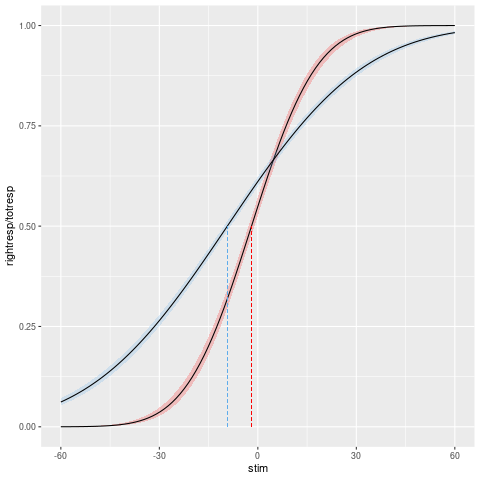

In [55]:
%%R
ilink <- family(fitmodel_logit_groupalert)$linkinv
pd_alert <- with(r_group_alert,
           data.frame(stim = seq(min(stim), max(stim),
                                       length = 100)))
pd_alert <- cbind(pd_alert, predict(fitmodel_logit_groupalert, pd_alert, type = "link", se.fit = TRUE)[1:2])
pd_alert <- transform(pd_alert, Fitted = ilink(fit), Upper = ilink(fit + (2 * se.fit)),
                Lower = ilink(fit - (2 * se.fit)))

ilink <- family(fitmodel_logit_groupdrowsy)$linkinv
pd_drowsy <- with(r_group_drowsy,
           data.frame(stim = seq(min(stim), max(stim),
                                       length = 100)))
pd_drowsy <- cbind(pd_drowsy, predict(fitmodel_logit_groupdrowsy, pd_drowsy, type = "link", se.fit = TRUE)[1:2])
pd_drowsy <- transform(pd_drowsy, Fitted = ilink(fit), Upper = ilink(fit + (2 * se.fit)),
                Lower = ilink(fit - (2 * se.fit)))

ggplot(data = r_group_alert, aes(x = stim, y = rightresp/totresp)) +
    geom_ribbon(data = pd_alert, aes(ymin = Lower, ymax = Upper, x = stim),
                fill = "red", alpha = 0.2, inherit.aes = FALSE) +
    geom_line(data = pd_alert, aes(y = Fitted, x = stim))+

geom_ribbon(data = pd_drowsy, aes(ymin = Lower, ymax = Upper, x = stim),
                fill = "steelblue2", alpha = 0.2, inherit.aes = FALSE) +
    geom_line(data = pd_drowsy, aes(y = Fitted, x = stim)) + 

geom_segment(aes(x=mean_groupalert,xend=mean_groupalert,y=0,yend=0.5), 
             size = 0.1, linetype  = "dashed", color="red") +
geom_segment(aes(x=mean_groupdrowsy,xend=mean_groupdrowsy,y=0,yend=0.5),
             size = 0.1,linetype  = "dashed", color="steelblue2")

In [56]:
pd_alert = robjects.r('pd_alert')
pd_drowsy = robjects.r('pd_drowsy')
r_group_alert = robjects.r('r_group_alert')
r_group_drowsy = robjects.r('r_group_drowsy')

print(pd_alert.head())
print(pd_drowsy.head())
print(r_group_alert.head())
print(r_group_drowsy.head())

        stim       fit    se.fit    Fitted     Upper     Lower
1 -60.000000 -3.716016  0.124602  0.000101  0.000263  0.000037
2 -58.787879 -3.638452  0.122167  0.000137  0.000344  0.000052
3 -57.575758 -3.560889  0.119734  0.000185  0.000448  0.000072
4 -56.363636 -3.483325  0.117305  0.000248  0.000580  0.000100
5 -55.151515 -3.405762  0.114879  0.000330  0.000747  0.000139
        stim       fit    se.fit    Fitted     Upper     Lower
1 -60.000000 -1.540485  0.035986  0.061721  0.070982  0.053431
2 -58.787879 -1.503655  0.035347  0.066335  0.075934  0.057704
3 -57.575758 -1.466824  0.034710  0.071212  0.081146  0.062239
4 -56.363636 -1.429994  0.034076  0.076359  0.086624  0.067048
5 -55.151515 -1.393164  0.033446  0.081785  0.092375  0.072137
   subj_idx  stim  leftresp  rightresp  totresp  state
1       2.0 -60.0       2.0        0.0      2.0  Alert
2       2.0 -55.0       2.0        0.0      2.0  Alert
3       2.0 -50.0       2.0        0.0      2.0  Alert
4       2.0 -45.0       

In [57]:
group_df

,subjid,xseq,yseq,Condition
110,2.0,-60.000000,2.220446e-16,Alert
2,2.0,-58.787879,2.220446e-16,Alert
3,2.0,-57.575758,2.220446e-16,Alert
4,2.0,-56.363636,2.220446e-16,Alert
5,2.0,-55.151515,2.220446e-16,Alert
...,...,...,...,...
9631,46.0,55.151515,9.991792e-01,Drowsy
9731,46.0,56.363636,9.993235e-01,Drowsy
9831,46.0,57.575758,9.994441e-01,Drowsy
9931,46.0,58.787879,9.995445e-01,Drowsy


In [58]:
group_df.subjid.unique()

array([ 2.,  4.,  5.,  6.,  7.,  9., 10., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       41., 42., 43., 44., 45., 46.])

In [59]:
pal = {Condition: "b" if Condition == 'Drowsy' else "r" for Condition in group_df.Condition.unique()}

In [64]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
output_dir = 'decArsousalDecisionmaking_JNeuroscience2021/Figures/'

In [65]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Figures/'

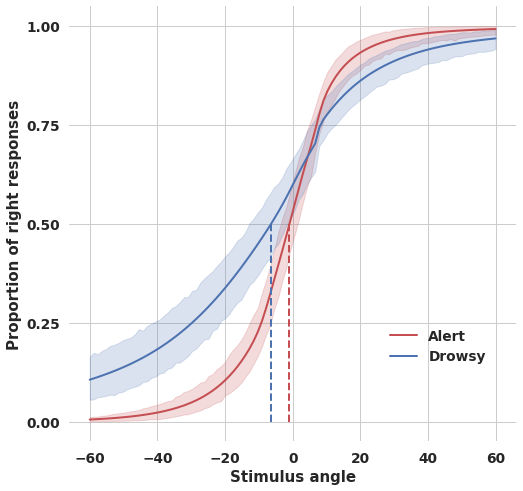

In [66]:
f, (ax1) = plt.subplots(figsize=(8, 8))

ax2 = sns.lineplot(x="xseq",y="yseq",hue='Condition',data=group_df,ax=ax1, 
                    markers=False, style="Condition", dashes=False,
                    palette=pal,linewidth = 2);

alertmean_val = -1 #manually calculated as the fits are made on indiv subjects and just averaged here..
x1 = [alertmean_val, 
      alertmean_val]
y1 = [0, 0.5]
ax1.plot(x1, y1,'--r', linewidth=2)

drowsymean_val = -6.5 #manually calculated as the fits are made on indiv subjects and just averaged here..
x1 = [drowsymean_val, 
      drowsymean_val]
y1 = [0, 0.5]
ax1.plot(x1, y1,'--b', linewidth=2)

ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_xlabel('Stimulus angle')
ax1.set_ylabel('Proportion of right responses')

ax1.legend(['Alert','Drowsy'],loc='lower left', bbox_to_anchor=(0.69, 0.15),framealpha=0.0)

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()

tmpval = ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])

tmpval = ax1.set_xticks(np.arange(-60,70,20))
plt.box(False)
ax1.grid(True)
plt.savefig(fig_dir + "grouplevel_bias.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)

In [81]:
len(np.unique(df_myplotdata.subj_idx))

32

In [84]:
# example rightshifer: 23
# example leftshifer: 6

In [115]:
def plotsubj_biasshift(subject_id, ax, xlabel, ylabel, title):
    
    #print('processing subject: ', str(subject_id))
    
    # alert data plot..
    plotdata = df_myplotdata[(df_myplotdata.state=='Alert') &\
                             (df_myplotdata.subj_idx==subject_id)]
    
    size = np.asarray(plotdata['totresp'])
    stim = np.asarray(plotdata['stim'])
    p_right = np.asarray(plotdata['p_right'])
    
    plotdf_alert = df_alert[df_alert.subjid==subject_id]
    xseq = np.asarray(plotdf_alert['xseq'])
    yseq = np.asarray(plotdf_alert['yseq'])
    
    
    ax.scatter(stim ,p_right, marker="o", s = 1000*size/np.sum(size), alpha=0.8,
                         color = 'r',edgecolors = 'k',linewidths = 2)
    
    
    ax.plot(xseq, yseq, '-r',alpha=0.5, linewidth=3);
    
    
    # drowsy data plot..
    plotdata = df_myplotdata[(df_myplotdata.state=='Drowsy') &\
                             (df_myplotdata.subj_idx==subject_id)]
    
    size = np.asarray(plotdata['totresp'])
    stim = np.asarray(plotdata['stim'])
    p_right = np.asarray(plotdata['p_right'])

    plotdf_drowsy = df_drowsy[df_drowsy.subjid==subject_id]
    xseq = np.asarray(plotdf_drowsy['xseq'])
    yseq = np.asarray(plotdf_drowsy['yseq'])

    ax.scatter(stim ,p_right, marker="o", s = 1000*size/np.sum(size), alpha=0.8,
                  color = 'b',edgecolors = 'k',linewidths = 2)
    
    ax.plot(xseq, yseq, '-b',alpha=0.5, linewidth=3)
    
    # legend, mid-line plots..
    ax.legend(['Alert','Drowsy'],loc='lower left', bbox_to_anchor=(0.69, 0.15),framealpha=0.0)

    x1 = [float(df_stats[df_stats.subj_id==str(subject_id)].alertmean), 
          float(df_stats[df_stats.subj_id==str(subject_id)].alertmean)]
    y1 = [0, 0.5]
    ax.plot(x1, y1,'--r', linewidth=2)

    x1 = [float(df_stats[df_stats.subj_id==str(subject_id)].drowsymean), 
          float(df_stats[df_stats.subj_id==str(subject_id)].drowsymean)]
    y1 = [0, 0.5]
    ax.plot(x1, y1,'--b', linewidth=2)

    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.set_frame_on(False)
    ax.set_title(title,fontsize=label_fontsize, weight = 'bold')
    

In [116]:
subjects = ['02','04','05','06','07','09','10','20','21','22',\
            '23','24','25','26','27','28','30','31','32','33',\
            '34','35','36','37','38','39','41','42','43','44',\
            '45','46']

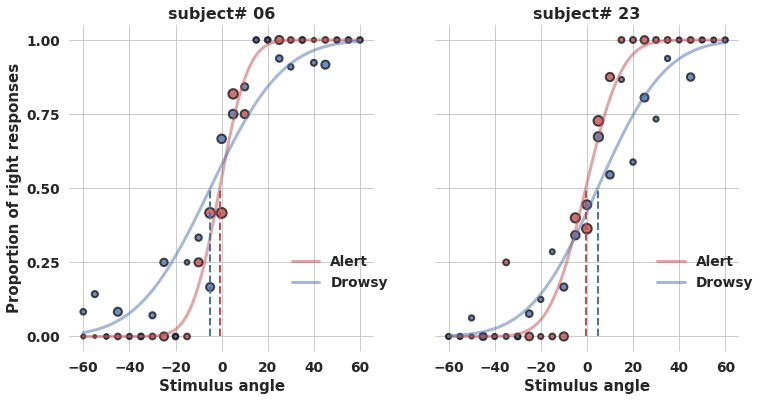

In [121]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12, 6))
plotsubj_biasshift(subject_id = int(subjects[3]), ax = ax[0], xlabel = 'Stimulus angle', 
                   ylabel = 'Proportion of right responses', title = 'subject#' + ' ' + subjects[3])
plotsubj_biasshift(subject_id = int(subjects[10]), ax = ax[1], xlabel = 'Stimulus angle', 
                   ylabel = '', title = 'subject#' + ' ' + subjects[10])

plt.savefig(fig_dir + "shifters.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)

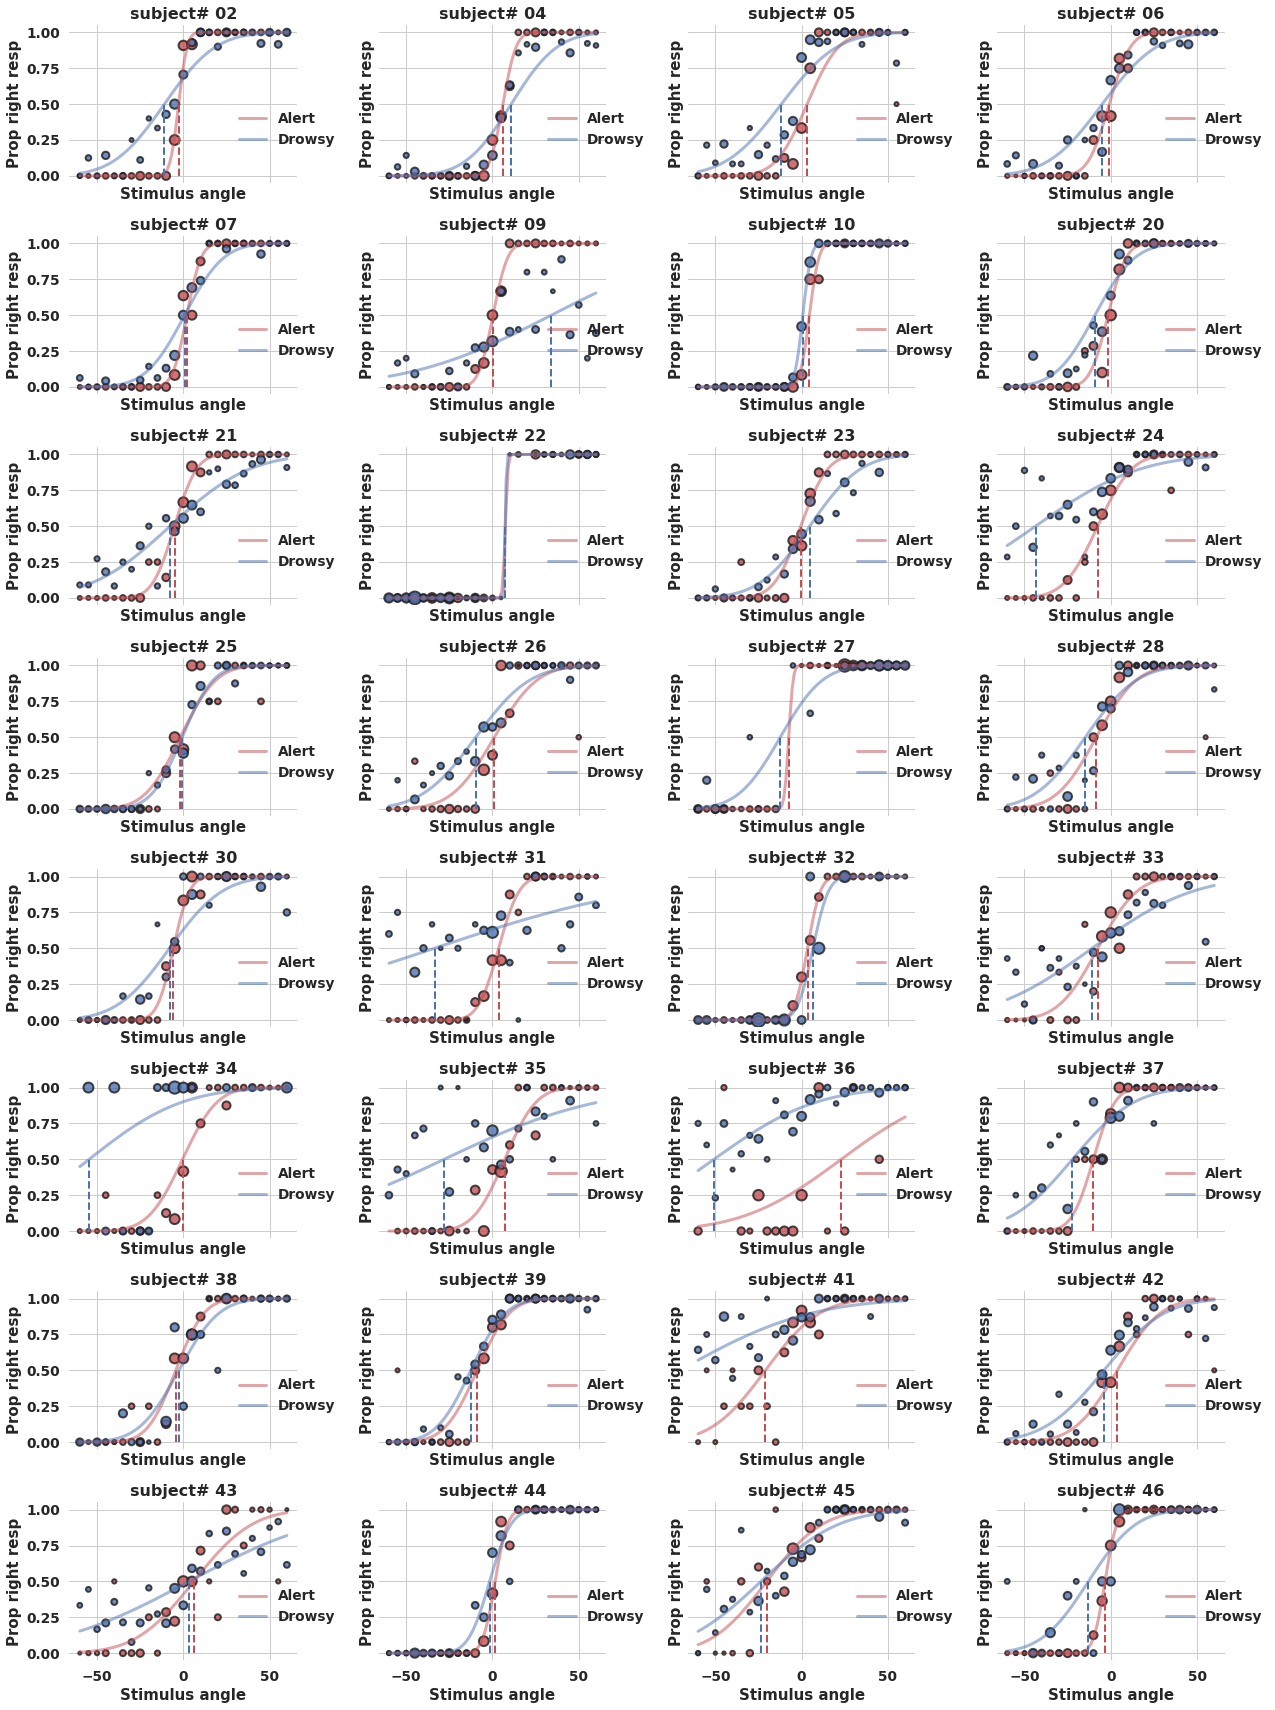

In [122]:
tPlot, axes = plt.subplots(figsize=(18, 24),
        nrows=8, ncols=4, sharex=True, sharey=True)

for s, subject in enumerate(subjects):  # Loop across each subject
        rowidx = s//4
        colidx = s%4
        titlestr = 'subject#' + ' ' + subject
        plotsubj_biasshift(subject_id = int(subject), ax = axes[rowidx,colidx], xlabel = 'Stimulus angle', 
                   ylabel = 'Prop right resp', title = titlestr)
        
plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "suppl_shifters_allsubject.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)

In [123]:
print('alertmean: ' ,df_stats['alertmean'].mean())
print('drowsymean: ' ,df_stats['drowsymean'].mean())

alertmean:  -1.36609447994487
drowsymean:  -10.378948062399783


In [130]:
df_stats.subj_id.unique()

array(['2', '4', '5', '6', '7', '9', '10', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '41', '42', '43', '44', '45', '46'], dtype=object)

In [140]:
df_stats

,subj_id,alertmean,alertstd,drowsymean,drowsystd,meandiff
1,2,-2.706761,3.881901,-10.963470,23.331968,8.256709
2,4,6.098175,6.009543,10.862557,21.000076,-4.764382
3,5,3.242519,14.393248,-11.743692,25.404265,14.986211
4,6,-0.842134,9.687243,-4.926331,24.786227,4.084198
5,7,2.069948,6.460131,0.784984,17.708869,1.284964
6,9,0.356698,6.605309,34.155427,NaN,-33.798730
7,10,4.545598,4.270522,0.725600,3.665293,3.819997
8,20,-1.570211,8.191219,-9.118050,18.026250,7.547839
9,21,-5.094446,10.083819,-7.685210,NaN,2.590764
10,22,7.475780,1.232483,7.486821,0.441265,-0.011041


In [125]:
#Perform stats on the bias data..
from scipy import stats
(t_stat,p_val) = stats.ttest_rel(df_stats.dropna()['alertmean'], df_stats.dropna()['drowsymean'])
df_test = len(df_stats.dropna())-1
print('Stats on RT data: t-val is ',round(t_stat,2), ' p_val is ',p_val, ' df is :', df_test)

Stats on RT data: t-val is  3.33  p_val is  0.003337023004137863  df is : 20


In [131]:
df1 = pd.DataFrame({'Condition' : 'Alert', 'mean': df_stats.alertmean, 'subjects': df_stats.subj_id})
df2 = pd.DataFrame({'Condition' : 'Drowsy', 'mean': df_stats.drowsymean, 'subjects': df_stats.subj_id})
df_biasshift = pd.concat([df1,df2])

In [132]:
print(df_biasshift.head())
print(df_biasshift.tail())

  Condition      mean subjects
1     Alert -2.706761        2
2     Alert  6.098175        4
3     Alert  3.242519        5
4     Alert -0.842134        6
5     Alert  2.069948        7
   Condition       mean subjects
28    Drowsy  -3.931060       42
29    Drowsy   3.386901       43
30    Drowsy  -1.619225       44
31    Drowsy -23.530758       45
32    Drowsy -12.894788       46


In [133]:
df_biasshift.Condition.unique()

array(['Alert', 'Drowsy'], dtype=object)

In [ ]:
pal = {Condition: "b" if Condition == 'Drowsy' else "r" for Condition in df_biasshift.Condition.unique()}

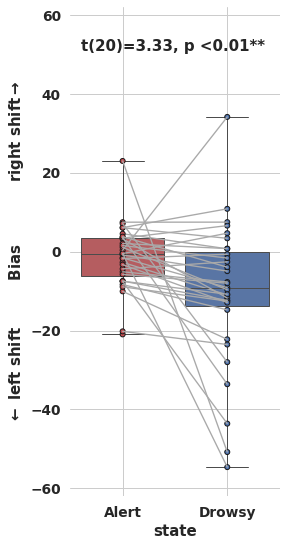

In [144]:
f, (ax1) = plt.subplots(ncols=1, sharex=True, figsize=(3.75, 9))

ax2 = sns.pointplot(x="Condition",y="mean",hue='subjects',data=df_biasshift,ax=ax1, dodge=0.0, scale = 0.5, 
                    palette=['darkgray'],markers = '', linewidth = 0.15)

sns.boxplot(x="Condition", y="mean", data=df_biasshift, whis=np.inf, ax=ax1, showbox=True,dodge=False,
            meanline=True,showmeans=False, showfliers=True,showcaps=True,palette=pal,linewidth=1)
sns.stripplot(x="Condition", y="mean", data=df_biasshift,jitter=False, linewidth=1, ax=ax1,
              edgecolor ="k",palette=pal)

ax1.legend_.remove()


# left,rightshifters annotation
x = -0.4
y = 52
col = 'k' 


string_val = 't(20)=' + str(round(t_stat,2)) + ', p' + ' <0.01**'
ax1.text(x, y, string_val, va='center', fontweight='bold',rotation='horizontal')

ax1.set_ylim(-62, 62)
plt.ylabel(r'$\leftarrow$ left shift         Bias            right shift$\rightarrow$', 
           fontweight = 'bold', rotation=90)

ax1.set_xlabel('state')

plt.box(False)
ax1.grid(True)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()

plt.savefig(fig_dir + "bias.png", bbox_inches = 'tight', pad_inches = 0.1, format='png',
            dpi=240, transparent=False)